In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf

img_folder = 'img_align_celeba\\'
imagens_atributes = 'celeb_attributes.csv'
videos_table_path_validation = 'celeb_bbox.csv'
max_cases_per_split = 10000
batch_size = 16
preprocess_training_test = False
preprocess_validation = True
input_size = (128,128)

In [ ]:
input_size = (128,128)
images = pd.read_csv(imagens_atributes, sep=";")
bbox = pd.read_csv(videos_table_path_validation, sep=";")
data = images.merge(bbox)
data.loc[data['Male']==-1, 'Male'] = 0

# BALANCE
male = data[data['Male']==1]
female = data[data['Male']!=1].head(len(male))
data = pd.concat([male, female], ignore_index=True)

#SHUFFLE
data = data.sample(frac=1)

def load_reshape_img(fname):
    img = tf.keras.preprocessing.image.load_img(fname)
    x = tf.keras.preprocessing.image.img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)    
    return img

def process_path(index):
    file_path = img_folder + '\\' + data.iloc[index]['file']
    img = tf.io.read_file(file_path, )
    img = decode_img(img)
    #(x,y,w,h) = data.iloc[index][['x_1','y_1','width', 'height']].values
    #img = img[x:x+w,y:y+h]
    #img = cv.resize(img, input_size)
    return img

def process_dataframe(dataframe):
    with tf.device('/cpu:0'):
        xs = np.array([load_reshape_img(img_folder + fname) for fname in dataframe.file])
        xs = xs.reshape(xs.shape[0], 218, 178, 3)
        ys = tf.keras.utils.to_categorical(dataframe['Male'], 2)
    return xs, ys

train_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

In [ ]:
IMG_SHAPE = (218, 178, 3)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax'),
    ])



# model = tf.keras.Model(base_model.input, x)
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])#, tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]) #

In [ ]:
model.save('cnn_vgg16_pretrainned_gender_recognition_v1')

INFO:tensorflow:Assets written to: cnn_vgg16_pretrainned_gender_recognition_v1\assets


In [ ]:
model = tf.keras.models.load_model('cnn_vgg16_pretrainned_gender_recognition_v1')

In [ ]:
count = 0
split_count = int(len(data)/max_cases_per_split)
for split in np.array_split(data, split_count):
    print('Split' + str(count))
    train_count = int(len(split) * 0.7)
    train_df = split.head(train_count)
    test_df = split.tail(len(split) - train_count)
    x_train, y_train = process_dataframe(train_df)
    x_test, y_test = process_dataframe(test_df)
    train_datagen.fit(x_train)
    train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size,)
    
    history = model.fit(train_generator, steps_per_epoch=train_count/batch_size,  epochs=100, callbacks=[ tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)])
    print('####################################################################################')
    print('#############################Split' + str(count) + 'Test ###########################')
    print('####################################################################################')
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0, batch_size=1)
    print('Test accuracy:' + str( test_acc))
    print('####################################################################################')
    
    model.save('cnn_vgg16_pretrainned_gender_recognition_v1')
    count += 1

Split0
Epoch 1/100
462/461 [==============================] - 48s 105ms/step - loss: 0.3979 - accuracy: 0.8303
Epoch 2/100
462/461 [==============================] - 47s 103ms/step - loss: 0.3000 - accuracy: 0.8753
Epoch 3/100
462/461 [==============================] - 48s 103ms/step - loss: 0.2912 - accuracy: 0.8774
Epoch 4/100
462/461 [==============================] - 49s 107ms/step - loss: 0.2766 - accuracy: 0.8847
Epoch 5/100
462/461 [==============================] - 49s 106ms/step - loss: 0.2706 - accuracy: 0.8878
Epoch 6/100
462/461 [==============================] - 48s 104ms/step - loss: 0.2595 - accuracy: 0.8852
Epoch 7/100
462/461 [==============================] - 47s 102ms/step - loss: 0.2511 - accuracy: 0.8944
Epoch 8/100
462/461 [==============================] - 47s 103ms/step - loss: 0.2548 - accuracy: 0.8937
Epoch 9/100
462/461 [==============================] - 47s 102ms/step - loss: 0.2367 - accuracy: 0.9011
Epoch 10/100
462/461 [==============================] - 4

MemoryError: Unable to allocate 3.20 GiB for an array with shape (7387, 1, 218, 178, 3) and data type float32

In [ ]:
test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0, batch_size=1)
print('Test accuracy:' + str( test_acc))# + 'Test precision:' + str( test_prec) + 'Test recall:' + str( test_rec))

Test accuracy:1.0


In [ ]:
split_count = int(len(data)/max_cases_per_split)
split = np.array_split(data, split_count)[0]
train_count = int(len(split) * 0.7)
train_df = split.head(train_count)
test_df = split.tail(len(split) - train_count)
#x_train, y_train = process_dataframe(train_df)
x_test, y_test = process_dataframe(test_df)

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [ ]:
preds = [np.argmax(model(np.expand_dims(x,0))) for x in x_test]

In [ ]:
features = np.array([list(x[0].numpy()) for x in list(data_ds)])
labels = np.array([x[1].numpy() for x in list(data_ds)])

In [ ]:
img = np.expand_dims( features[1], 0)
model.predict(img)

array([[1.]], dtype=float32)

In [ ]:
r = [int(x[1]) for x in list(test_ds)]

In [ ]:
([x[1].numpy() for x in list(test_ds)])

array([0, 0, 0, ..., 1, 0, 1])

In [ ]:
features = np.array([list(x[0].numpy()) for x in list(test_ds)])
labels = np.array(r)
test_loss, test_acc, test_prec, test_rec = model.evaluate(x=features, y=labels, verbose=0)

print('\nTest accuracy:', test_acc)
print('\nTest precision:', test_prec)
print('\nTest recall:', test_rec)

NameError: name 'test_ds' is not defined

In [ ]:
def load_caffe_model():
    return cv.dnn.readNetFromCaffe('deploy_gender.prototxt', 'gender_net.caffemodel')

gender_net = load_caffe_model()

In [ ]:
preds = []
MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
for img in features[:100]:
    blob = cv.dnn.blobFromImage(img, 1, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
    gender_net.setInput(blob)
    gender_preds = gender_net.forward()
    preds.append(gender_preds[0].argmax())

array([[0.01312369, 0.98687637]], dtype=float32)

In [ ]:
labels[:10]

array([False,  True, False, False, False, False,  True,  True, False,
        True])

In [ ]:
training = [0.8303 ,0.8753 ,0.8774 ,0.8847 ,0.8878 ,0.8852 ,0.8944 ,0.8937 ,0.9011 ,0.8969 ,0.8974 ,0.8979 ,0.9057 ,0.9090 ,0.9130 ,0.9058 ,0.9117 ,0.9124 ,0.9135 ,0.9135 ,0.9132 ,0.9187 ,0.9196 ,0.9146 ,0.9207 ,0.9172 ,0.9242 ,0.9192 ,0.9250 ,0.9212 ,0.9269 ,0.9214 ,0.9254 ,0.9289 ,0.9318 ,0.9288 ,0.9319 ,0.9295 ,0.9276 ,0.9318 ,0.9356 ,0.9316 ,0.9353 ,0.9360 ,0.9346 ,0.9369 ,0.9342 ,0.9349 ,0.9414 ,0.9411 ,0.9375 ,0.9423 ,0.9399 ,0.9414 ,0.9433 ,0.9415 ,0.9442 ,0.9434 ,0.9450 ,0.9446 ,0.9445 ,0.9491 ,0.9448 ,0.9461 ,0.9475 ,0.9457 ,0.9511 ,0.9475 ,0.9480 ,0.9487 ,0.9506 ,0.9491 ,0.9522 ,0.9533 ,0.949 ,0.953 ,0.951 ,0.9509 ,0.9537 ,0.9521 ,0.9533 ,0.9547 ,0.9549 ,0.9506 ,0.9555 ,0.9555 ,0.9549 ,0.9566 ,0.9566 ,0.9579 ,0.9543 ,0.9607 ,0.9603 ,0.9595 ,0.9606 ,0.9586 ,0.9561 ,0.9574 ,0.9629 ,0.9584 ,0.9042 ,0.9147 ,0.9151 ,0.9226 ,0.9187 ,0.9243 ,0.9196 ,0.9251 ,0.9203 ,0.9257 ,0.9234 ,0.9228 ,0.9292 ,0.9272 ,0.9274 ,0.9281 ,0.9315 ,0.9322 ,0.9325 ,0.9308 ,0.9333 ,0.9319 ,0.9338 ,0.9348 ,0.9345 ,0.9369 ,0.9388 ,0.9398 ,0.9377 ,0.9418 ,0.9450 ,0.9395 ,0.9392 ,0.9415 ,0.9437 ,0.9449 ,0.9418 ,0.9513 ,0.9465 ,0.9507 ,0.9467 ,0.9479 ,0.9452 ,0.9475 ,0.9483 ,0.9491 ,0.9521 ,0.9513 ,0.9495 ,0.9548 ,0.9526 ,0.9519 ,0.9515 ,0.9540 ,0.9552 ,0.9534 ,0.9525 ,0.9532 ,0.9502 ,0.9528 ,0.9549 ,0.9583 ,0.9574 ,0.9561 ,0.9547 ,0.9567 ,0.9536 ,0.9566 ,0.9607 ,0.9597 ,0.9598 ,0.9559 ,0.9599 ,0.9582 ,0.9609 ,0.9586 ,0.9597 ,0.9622 ,0.9606 ,0.9612 ,0.9574 ,0.9648 ,0.9659 ,0.9613 ,0.9622 ,0.9624 ,0.9636 ,0.9640 ,0.9637 ,0.9641 ,0.9624 ,0.9649 ,0.9624 ,0.9643 ,0.9675 ,0.9685 ,0.9689 ,0.9671 ,0.9691 ,0.9685 ,0.9200 ,0.9192 ,0.9257 ,0.9296 ,0.9315 ,0.9288 ,0.9329 ,0.9302 ,0.9353 ,0.9341 ,0.9338 ,0.9391 ,0.9329 ,0.9392 ,0.9376 ,0.9362 ,0.9411 ,0.9419 ,0.9404 ,0.9409 ,0.9463 ,0.9432 ,0.9437 ,0.9410 ,0.9426 ,0.9476 ,0.9449 ,0.9448 ,0.9486 ,0.9486 ,0.9507 ,0.9514 ,0.9469 ,0.9501 ,0.9473 ,0.9511 ,0.9490 ,0.9537 ,0.9498 ,0.9518 ,0.9536 ,0.9560 ,0.9545 ,0.9529 ,0.9548 ,0.9563 ,0.9582 ,0.9593 ,0.9574 ,0.9536 ,0.9541 ,0.9612 ,0.9602 ,0.9597 ,0.9632 ,0.9606 ,0.9576 ,0.9628 ,0.9613 ,0.9602 ,0.9640 ,0.9587 ,0.9606 ,0.9626 ,0.9601 ,0.9628 ,0.9641 ,0.9653 ,0.9635 ,0.9624 ,0.9660 ,0.9636 ,0.9659 ,0.9682 ,0.9647 ,0.9668 ,0.9640 ,0.9681 ,0.9682 ,0.9649 ,0.9668 ,0.9651 ,0.9691 ,0.9672 ,0.9655 ,0.9681 ,0.9689 ,0.9701 ,0.9666 ,0.9705 ,0.9709 ,0.9685 ,0.9702 ,0.9694 ,0.9674 ,0.9705 ,0.9691 ,0.9713 ,0.9729 ,0.9727 ,0.9247 ,0.9276 ,0.9315 ,0.9296 ,0.9303 ,0.9326 ,0.9307 ,0.9321 ,0.9333 ,0.9337 ,0.9390 ,0.9368 ,0.9364 ,0.9394 ,0.9356 ,0.9394 ,0.9421 ,0.9406 ,0.9414 ,0.9457 ,0.9442 ,0.9415 ,0.9459 ,0.9496 ,0.9476 ,0.9490 ,0.9459 ,0.9453 ,0.9526 ,0.9482 ,0.9482 ,0.9487 ,0.9495 ,0.9534 ,0.9547 ,0.9525 ,0.9533 ,0.9515 ,0.9563 ,0.9541 ,0.9552 ,0.9553 ,0.9557 ,0.9551 ,0.9568 ,0.9564 ,0.9572 ,0.9593 ,0.9597 ,0.9572 ,0.9636 ,0.9595 ,0.9567 ,0.9614 ,0.9639 ,0.9593 ,0.9626 ,0.9583 ,0.9609 ,0.9607 ,0.9633 ,0.9626 ,0.9652 ,0.9607 ,0.9639 ,0.9599 ,0.9641 ,0.9635 ,0.9649 ,0.9649 ,0.9655 ,0.9636 ,0.9664 ,0.9678 ,0.9607 ,0.9674 ,0.9640 ,0.9667 ,0.9697 ,0.9712 ,0.9666 ,0.9674 ,0.9662 ,0.9682 ,0.9708 ,0.9721 ,0.9714 ,0.9716 ,0.9697 ,0.9731 ,0.9700 ,0.9685 ,0.9697 ,0.9691 ,0.9728 ,0.9723 ,0.9700 ,0.9724 ,0.9751 ,0.9677 ,0.9205 ,0.9235 ,0.9272 ,0.9269 ,0.9266 ,0.9280 ,0.9338 ,0.9295 ,0.9300 ,0.9293 ,0.9348 ,0.9362 ,0.9410 ,0.9358 ,0.9391 ,0.9388 ,0.9366 ,0.9395 ,0.9422 ,0.9414 ,0.9395 ,0.9421 ,0.9421 ,0.9468 ,0.9442 ,0.9452 ,0.9422 ,0.9446 ,0.9469 ,0.9522 ,0.9454 ,0.9510 ,0.9511 ,0.9523 ,0.9530 ,0.9526 ,0.9473 ,0.9515 ,0.9526 ,0.9506 ,0.9526 ,0.9533 ,0.9547 ,0.9545 ,0.9555 ,0.9529 ,0.9575 ,0.9552 ,0.9553 ,0.9542 ,0.9568 ,0.9591 ,0.9571 ,0.9591 ,0.9578 ,0.9576 ,0.9584 ,0.9618 ,0.9609 ,0.9629 ,0.9601 ,0.9614 ,0.9648 ,0.9588 ,0.9629 ,0.9649 ,0.9614 ,0.9624 ,0.9648 ,0.9617 ,0.9645 ,0.9644 ,0.9633 ,0.9647 ,0.9601 ,0.9653 ,0.9640 ,0.9663 ,0.9640 ,0.9243 ,0.9292 ,0.9308 ,0.9348 ,0.9324 ,0.9339 ,0.9331 ,0.9327 ,0.9369 ,0.9366 ,0.9366 ,0.9379 ,0.9388 ,0.9380 ,0.9425 ,0.9442 ,0.9460 ,0.9398 ,0.9467 ,0.9441 ,0.9442 ,0.9468 ,0.9472 ,0.9461 ,0.9487 ,0.9483 ,0.9491 ,0.9486 ,0.9475 ,0.9514 ,0.9514 ,0.9523 ,0.9500 ,0.9563 ,0.9538 ,0.9552 ,0.9532 ,0.9505 ,0.9545 ,0.9564 ,0.9548 ,0.9549 ,0.9540 ,0.9568 ,0.9556 ,0.9593 ,0.9607 ,0.9583 ,0.9591 ,0.9586 ,0.9582 ,0.9605 ,0.9593 ,0.9613 ,0.9601 ,0.9618 ,0.9599 ,0.9651 ,0.9634 ,0.9655 ,0.9652 ,0.9633 ,0.9647 ,0.9636 ,0.9636 ,0.9625 ,0.9639 ,0.9662 ,0.9675 ,0.9647 ,0.9660 ,0.9687 ,0.9652 ,0.9701 ,0.9687 ,0.9697 ,0.9658 ,0.9647 ,0.9653 ,0.9660 ,0.9697 ,0.9683 ,0.9653 ,0.9679 ,0.9668 ,0.9733 ,0.9675 ,0.9702 ,0.9676 ,0.9728 ,0.9721 ,0.9683 ,0.9705 ,0.9709 ,0.9704 ,0.9724 ,0.9712 ,0.9731 ,0.9710 ,0.9764]
test = [0.9239027500152588 ,0.921692430973053 ,0.9276918172836304 ,0.9324281811714172 ,0.9355857372283936 ,0.9387432932853699]

training = [f*100 for f in training]
test = [f*100 for f in test]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.ticker as mtick


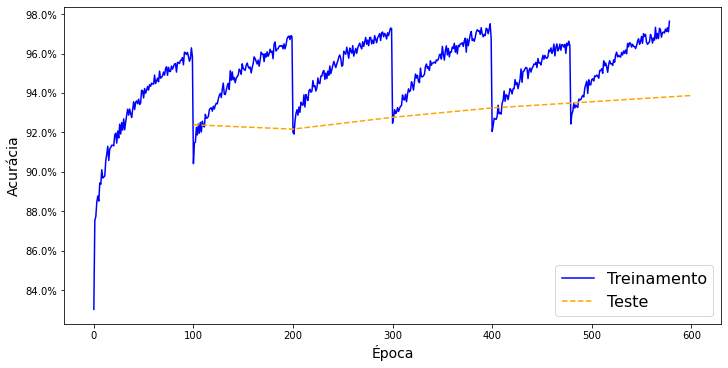

In [ ]:
fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
#fig.subtitle('Evolução do treinamento, modelo de identificação de gênero', fontsize=24)

sns.lineplot(x=range(len(training)), y=training, ax=ax, label='Treinamento', color='blue')
sns.lineplot(x=range(100,601,100), y=test, ax=ax, label='Teste', color='orange')#, markers=True, dashes=False)
ax.set_xlabel('Época', fontsize=14)
ax.set_ylabel('Acurácia', fontsize=14)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.lines[1].set_linestyle("--")
ax.legend(fontsize=16)



In [ ]:
list(range(100,601,100))

[100, 200, 300, 400, 500, 600]

In [ ]:
len(training)

579

In [ ]:
fig.savefig('treinamento-modelo-genero')

In [ ]:
training

In [ ]:
end_cycles = [0.9629
,0.9691
,0.9729
,0.9751
,0.9663
,0.9764]

In [ ]:
import numpy as np

np.mean(test)

93.00073683261871